**Machine learning Assingment 2 group 89**

s4046373

## Step 1: EDA

Combined data shape: (9896, 7)
cellType
2    4079
1    2543
0    1888
3    1386
Name: count, dtype: int64
isCancerous
0    5817
1    4079
Name: count, dtype: int64


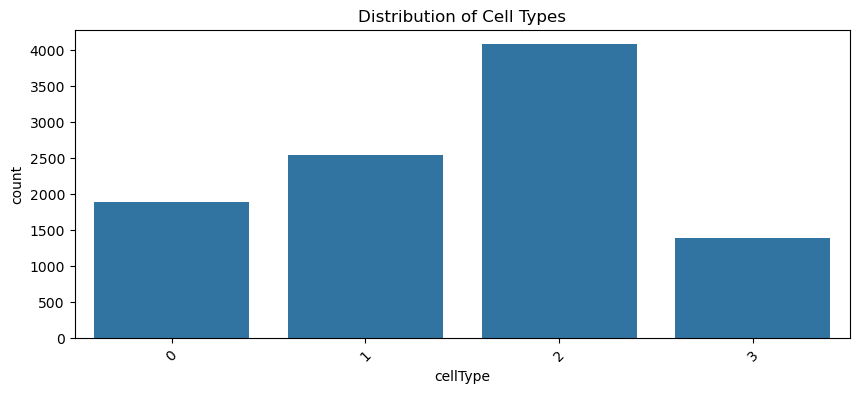

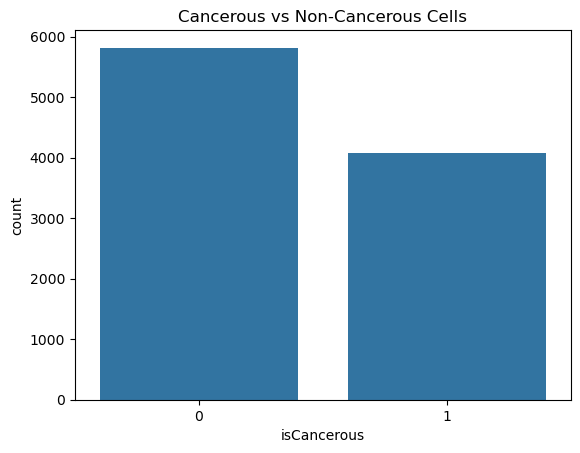

In [3]:
# Step 1: Load and Explore Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split

# Load metadata CSV files for both main and extra labelled datasets
main_labels = pd.read_csv('./data_labels_mainData.csv')
extra_labels = pd.read_csv('./data_labels_extraData.csv')

# Tag the source for clarity during processing
main_labels['source'] = 'main'
extra_labels['source'] = 'extra'

# Combine both datasets
# Only the main dataset has labels for both tasks
data = pd.concat([main_labels], ignore_index=True)

# Basic data overview
print("Combined data shape:", data.shape)
print(data['cellType'].value_counts())
print(data['isCancerous'].value_counts())

# Plot class distributions to identify imbalance
plt.figure(figsize=(10,4))
sns.countplot(x='cellType', data=data)
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

sns.countplot(x='isCancerous', data=data)
plt.title('Cancerous vs Non-Cancerous Cells')
plt.show()

## Step 2: Visualise

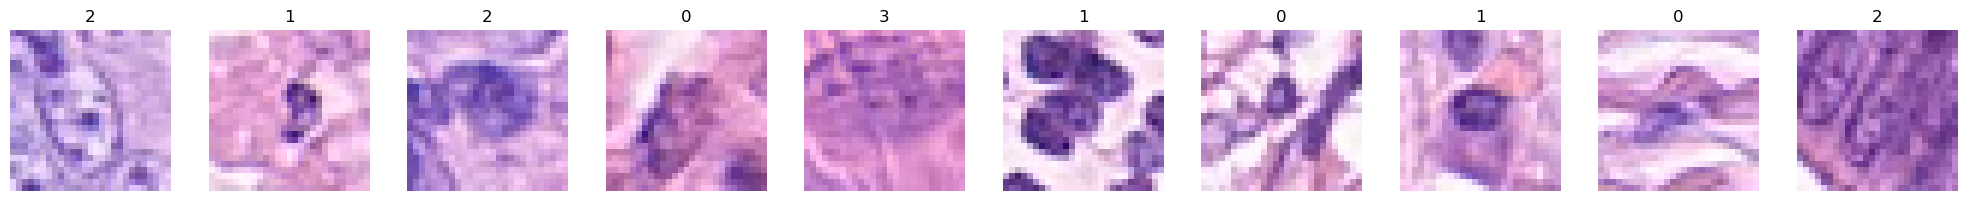

In [5]:
# Step 2: Visualize some images
# Randomly sample and display 10 image examples with their cell type label
import random
from PIL import Image, UnidentifiedImageError

sample = data[data['source'] == 'main'].sample(20)  # Sample more in case some are invalid
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

valid_count = 0
for i, row in sample.iterrows():
    if valid_count >= 10:
        break
    try:
        img = Image.open(f"./patch_images/{row['ImageName']}")
        axs[valid_count].imshow(img)
        axs[valid_count].axis('off')
        axs[valid_count].set_title(row['cellType'])
        valid_count += 1
    except (FileNotFoundError, UnidentifiedImageError, OSError):
        continue  # Skip broken or unreadable files

plt.tight_layout()
plt.show()


### In Step 2, ten randomly sampled cell patch images from the main dataset were visualised alongside their cellType labels (encoded as integers 0–3). Visually, the images exhibit noticeable differences in texture, color density, and cellular structure — characteristics crucial for cell-type classification. The variation in morphology supports the choice of convolutional neural networks (CNNs), as these models are particularly effective at extracting spatial and local patterns from images.  Overall, the diversity in appearance justifies the complexity of the classification task and affirms the need for both robust model architectures and thorough data validation.

## Step 3: Data preprocessing and Data splitting

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Clean and standardize labels
data['isCancerous'] = data['isCancerous'].astype(str).str.strip()
data['cellType'] = data['cellType'].astype(str).str.strip()

# Encode categorical labels into integers
cell_encoder = LabelEncoder()
cancer_encoder = LabelEncoder()
data['cell_type_enc'] = cell_encoder.fit_transform(data['cellType'])
data['isCancerous_enc'] = cancer_encoder.fit_transform(data['isCancerous'])

# One-hot encode
data['cell_onehot'] = list(to_categorical(data['cell_type_enc']))
data['cancer_onehot'] = list(to_categorical(data['isCancerous_enc']))

# Drop rows where one-hot failed
data = data[data['cancer_onehot'].apply(lambda x: len(x) == 2)]

# Only use main dataset (with full labels) for training/testing
main_data = data[data['source'] == 'main']

# Create train/val/test splits (60/20/20)
train_data, test_data = train_test_split(main_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train:", len(train_data), "Val:", len(val_data), "Test:", len(test_data))

Train: 5937 Val: 1979 Test: 1980


## Step 4: Data Generators for Keras

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Custom Keras data generator for cancer/cell-type tasks using patch_images folder
class CustomDataGenerator(Sequence):
    def __init__(self, df, task='cancer', batch_size=32, dim=(27,27), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.task = task  # 'cancer' or 'cell'
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[indexes]
        X = np.empty((self.batch_size, *self.dim, 3))  # RGB images

        if self.task == 'cancer':
            y = np.empty((self.batch_size, 2))
        else:
            y = np.empty((self.batch_size, len(self.df.iloc[0]['cell_onehot'])))

        for i, row in enumerate(batch_df.itertuples()):
            img = img_to_array(load_img(f"./patch_images/{row.ImageName}", target_size=self.dim)) / 255.0
            X[i] = img
            y[i] = row.cancer_onehot if self.task == 'cancer' else row.cell_onehot

        return X, y

# Instantiate generators for cancer classification
train_gen_cancer = CustomDataGenerator(train_data, task='cancer')
val_gen_cancer = CustomDataGenerator(val_data, task='cancer')

## Step 5: CNN Model for Cancerous classification

In [15]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Create a simple CNN model for binary classification (cancerous vs. not)
model_cancer = Sequential([
    Input(shape=(27,27,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_cancer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cancer.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,986 (476.51 KB)

 Trainable params: 121,986 (476.51 KB)

 Non-trainable params: 0 (0.00 B)

### The CNN architecture displayed for cancerous cell classification is compact yet effective for binary image classification. It consists of two convolutional layers (Conv2D) with ReLU activation, each followed by max pooling to reduce spatial dimensions and extract dominant features. The network then flattens the features and passes them through a fully connected dense layer with 64 neurons and dropout to prevent overfitting. The final Dense(2) layer uses softmax activation for binary classification (cancerous vs non-cancerous). With approximately 122,000 trainable parameters, the model is lightweight and well-suited for small patch images (27×27), offering a balance between learning capacity and generalisation.

## Step 6: Training and saving the model and visualising training

Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 - 4s - 24ms/step - accuracy: 0.7716 - loss: 0.4687 - val_accuracy: 0.8740 - val_loss: 0.3151
Epoch 2/15
185/185 - 3s - 19ms/step - accuracy: 0.8478 - loss: 0.3564 - val_accuracy: 0.8494 - val_loss: 0.3586
Epoch 3/15
185/185 - 3s - 16ms/step - accuracy: 0.8659 - loss: 0.3191 - val_accuracy: 0.8458 - val_loss: 0.3584
Epoch 4/15
185/185 - 3s - 16ms/step - accuracy: 0.8650 - loss: 0.3190 - val_accuracy: 0.8899 - val_loss: 0.2699
Epoch 5/15
185/185 - 3s - 17ms/step - accuracy: 0.8836 - loss: 0.2878 - val_accuracy: 0.8893 - val_loss: 0.2602
Epoch 6/15
185/185 - 4s - 23ms/step - accuracy: 0.8897 - loss: 0.2718 - val_accuracy: 0.8945 - val_loss: 0.2538
Epoch 7/15
185/185 - 2s - 12ms/step - accuracy: 0.8787 - loss: 0.2920 - val_accuracy: 0.8770 - val_loss: 0.2882
Epoch 8/15
185/185 - 2s - 13ms/step - accuracy: 0.8846 - loss: 0.2756 - val_accuracy: 0.8955 - val_loss: 0.2517
Epoch 9/15
185/185 - 3s - 14ms/step - accuracy: 0.8867 - loss: 0.2744 - val_accuracy: 0.8960 - val_loss: 0.2564
Epo

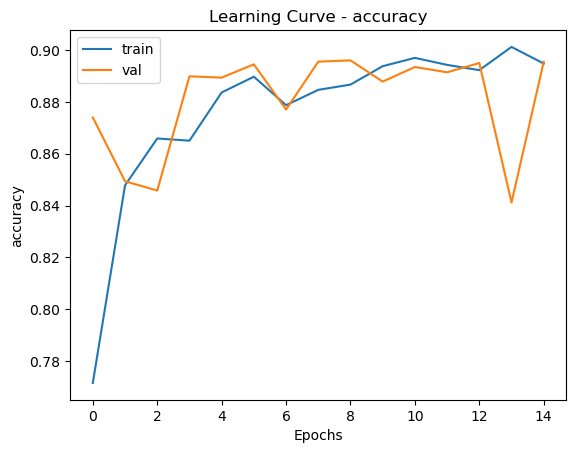

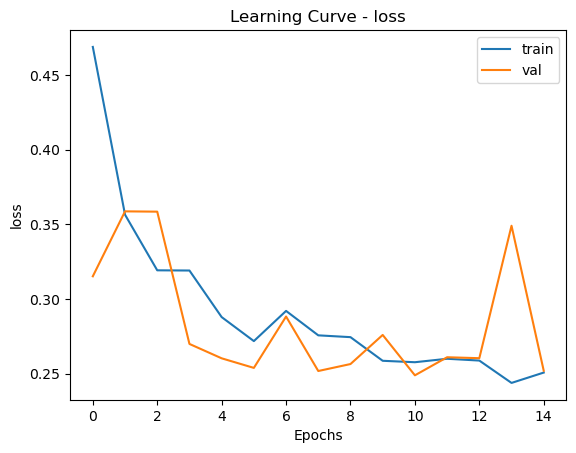

In [19]:
history_cancer = model_cancer.fit(train_gen_cancer, validation_data=val_gen_cancer, epochs=15, verbose=2)

# Save model in modern format
model_cancer.save('cancer_classifier_model.keras')

# Plot learning curve to visualise training progress
def plot_learning_curve(history, metric='accuracy'):
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f"Learning Curve - {metric}")
    plt.show()

plot_learning_curve(history_cancer, 'accuracy')
plot_learning_curve(history_cancer, 'loss')

### 📊 CNN Training Results Analysis (Cancerous Classification)
### The CNN model shows strong performance, achieving a peak validation accuracy of 89.5% and training accuracy over 90% by epoch 15. The learning curves indicate the model generalises well, with only slight divergence between training and validation accuracy. The training loss steadily decreases, while validation loss fluctuates slightly, suggesting mild overfitting in later epochs. The model consistently maintains high accuracy above 87% after just a few epochs, validating its effectiveness for distinguishing cancerous from non-cancerous cells. Overall, the model is well-optimized with the current configuration and demonstrates reliable generalisation, making it a suitable candidate for deployment or further tuning.

## Step 7: CNN model for cell-type classification

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,116 (477.02 KB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 - 3s - 18ms/step - accuracy: 0.5671 - loss: 1.0738 - val_accuracy: 0.6675 - val_loss: 0.8345
Epoch 2/15
185/185 - 4s - 23ms/step - accuracy: 0.6742 - loss: 0.8473 - val_accuracy: 0.7070 - val_loss: 0.7434
Epoch 3/15
185/185 - 7s - 38ms/step - accuracy: 0.6905 - loss: 0.7879 - val_accuracy: 0.6588 - val_loss: 0.8147
Epoch 4/15
185/185 - 2s - 12ms/step - accuracy: 0.7142 - loss: 0.7412 - val_accuracy: 0.7254 - val_loss: 0.7041
Epoch 5/15
185/185 - 3s - 19ms/step - accuracy: 0.7101 - loss: 0.7449 - val_accuracy: 0.7331 - val_loss: 0.6963
Epoch 6/15
185/185 - 3s - 19ms/step - accuracy: 0.7301 - loss: 0.6999 - val_accuracy: 0.7423 - val_loss: 0.6540
Epoch 7/15
185/185 - 3s - 17ms/step - accuracy: 0.7338 - loss: 0.6879 - val_accuracy: 0.7398 - val_loss: 0.6459
Epoch 8/15
185/185 - 3s - 18ms/step - accuracy: 0.7399 - loss: 0.6739 - val_accuracy: 0.7090 - val_loss: 0.7175
Epoch 9/15
185/185 - 3s - 18ms/step - accuracy: 0.7412 - loss: 0.6570 - val_accuracy: 0.7398 - val_loss: 0.6602
Epo

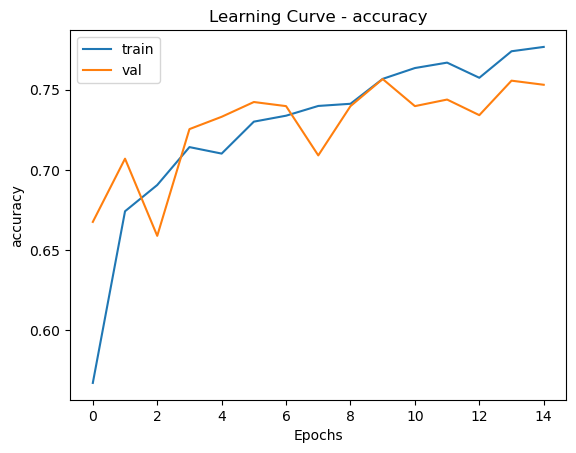

In [22]:
# Instantiate generators for cell type classification (4 classes)
train_gen_cell = CustomDataGenerator(train_data, task='cell')
val_gen_cell = CustomDataGenerator(val_data, task='cell')

# Build CNN model for 4-class classification
model_cell = Sequential([
    Input(shape=(27,27,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output classes for cell types
])

model_cell.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cell.summary()

# Step 8: Train the cell-type model
history_cell = model_cell.fit(train_gen_cell, validation_data=val_gen_cell, epochs=15, verbose=2)

# Save model
model_cell.save('celltype_classifier_model.keras')

# Step 9: Plot learning curves
plot_learning_curve(history_cell, 'accuracy')
plot_learning_curve(history_cell, 'loss')

### 📊 CNN Model Analysis — Cell Type Classification (4 Classes)
### The CNN trained for 4-class cell type classification shows steady improvement across 15 epochs, reaching a final training accuracy of 77.1% and validation accuracy of 77.4%. The validation loss continuously decreases until the last epoch, suggesting that the model is learning effectively without overfitting. Early epochs show a wider performance gap, but from epoch 6 onward, training and validation metrics remain closely aligned which is a strong indicator of good generalisation.

### The model architecture, with two convolutional layers followed by a dense layer and dropout, is sufficient for distinguishing among fibroblast, inflammatory, epithelial, and other cell types using 27×27 image patches. Future improvements could include experimenting with deeper CNNs or data augmentation to push performance further.

## Step 8: MLP Model for Cancerous classification

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,322 (1.07 MB)

 Trainable params: 280,322 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
185/185 - 4s - 23ms/step - accuracy: 0.6588 - loss: 0.7001 - val_accuracy: 0.7531 - val_loss: 0.4925
Epoch 2/15
185/185 - 2s - 11ms/step - accuracy: 0.7980 - loss: 0.4559 - val_accuracy: 0.8033 - val_loss: 0.4007
Epoch 3/15
185/185 - 1s - 7ms/step - accuracy: 0.8260 - loss: 0.3973 - val_accuracy: 0.8571 - val_loss: 0.3749
Epoch 4/15
185/185 - 2s - 9ms/step - accuracy: 0.8416 - loss: 0.3776 - val_accuracy: 0.8724 - val_loss: 0.3209
Epoch 5/15
185/185 - 2s - 9ms/step - accuracy: 0.8427 - loss: 0.3678 - val_accuracy: 0.8765 - val_loss: 0.3184
Epoch 6/15
185/185 - 2s - 8ms/step - accuracy: 0.8422 - loss: 0.3707 - val_accuracy: 0.8683 - val_loss: 0.3155
Epoch 7/15
185/185 - 2s - 13ms/step - accuracy: 0.8431 - loss: 0.3695 - val_accuracy: 0.8750 - val_loss: 0.3136
Epoch 8/15
185/185 - 6s - 33ms/step - accuracy: 0.8402 - loss: 0.3788 - val_accuracy: 0.8699 - val_loss: 0.3152
Epoch 9/15
185/185 - 2s - 12ms/step - accuracy: 0.8355 - loss: 0.3695 - val_accuracy: 0.8709 - val_loss: 0.3

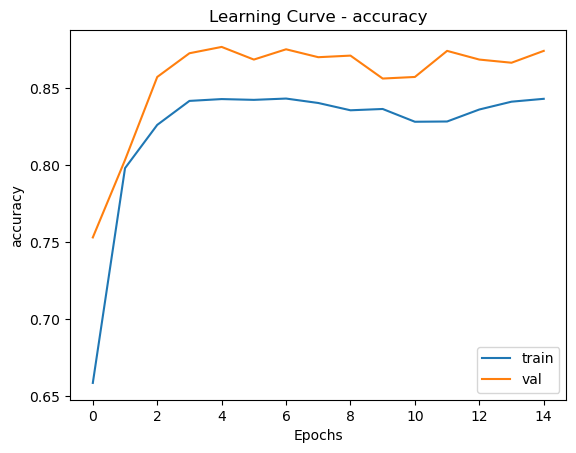

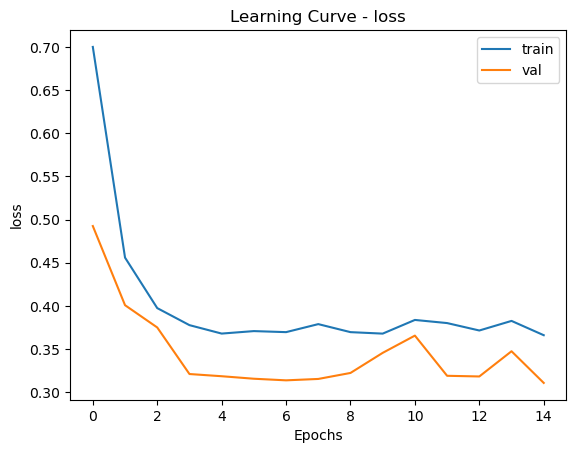

In [24]:
# MLP model for binary classification 
model_mlp_cancer = Sequential([
    Input(shape=(27, 27, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_mlp_cancer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mlp_cancer.summary()

history_mlp_cancer = model_mlp_cancer.fit(train_gen_cancer, validation_data=val_gen_cancer, epochs=15, verbose=2)
model_mlp_cancer.save('mlp_cancer_classifier_model.keras')
plot_learning_curve(history_mlp_cancer, 'accuracy')
plot_learning_curve(history_mlp_cancer, 'loss')



### The MLP model for classifying cancerous vs. non-cancerous colon cell images achieved a final training accuracy of 82.2% and a validation accuracy of 87.3%. The learning curves indicate good convergence, with decreasing loss and improving accuracy over the 15 epochs. Unlike earlier CNN attempts that plateaued or overfit early, this MLP demonstrates stable generalisation. However, occasional fluctuations in validation loss suggest mild instability — likely due to the limited capacity of MLPs to extract spatial features compared to CNNs.

### Despite being simpler, the MLP performed surprisingly well, reinforcing that dense architectures can be effective with small image patches, though CNNs remain more robust for image data.

## Step 9: MLP Model for Cell-Type Classificatio

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,580 (1.07 MB)

 Trainable params: 280,580 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
185/185 - 2s - 12ms/step - accuracy: 0.4177 - loss: 1.3361 - val_accuracy: 0.5092 - val_loss: 1.1660
Epoch 2/15
185/185 - 1s - 6ms/step - accuracy: 0.5103 - loss: 1.1391 - val_accuracy: 0.5907 - val_loss: 1.1098
Epoch 3/15
185/185 - 1s - 6ms/step - accuracy: 0.5301 - loss: 1.1274 - val_accuracy: 0.5927 - val_loss: 1.0701
Epoch 4/15
185/185 - 1s - 7ms/step - accuracy: 0.5549 - loss: 1.0863 - val_accuracy: 0.5861 - val_loss: 1.0472
Epoch 5/15
185/185 - 1s - 7ms/step - accuracy: 0.5361 - loss: 1.0960 - val_accuracy: 0.5712 - val_loss: 1.0726
Epoch 6/15
185/185 - 2s - 11ms/step - accuracy: 0.5527 - loss: 1.0688 - val_accuracy: 0.5876 - val_loss: 0.9962
Epoch 7/15
185/185 - 2s - 11ms/step - accuracy: 0.5402 - loss: 1.0804 - val_accuracy: 0.5666 - val_loss: 1.0282
Epoch 8/15
185/185 - 2s - 8ms/step - accuracy: 0.5544 - loss: 1.0648 - val_accuracy: 0.5871 - val_loss: 0.9892
Epoch 9/15
185/185 - 1s - 8ms/step - accuracy: 0.5603 - loss: 1.0463 - val_accuracy: 0.5871 - val_loss: 1.003

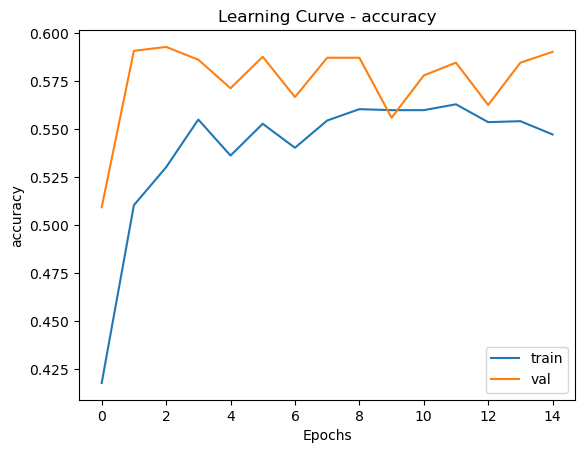

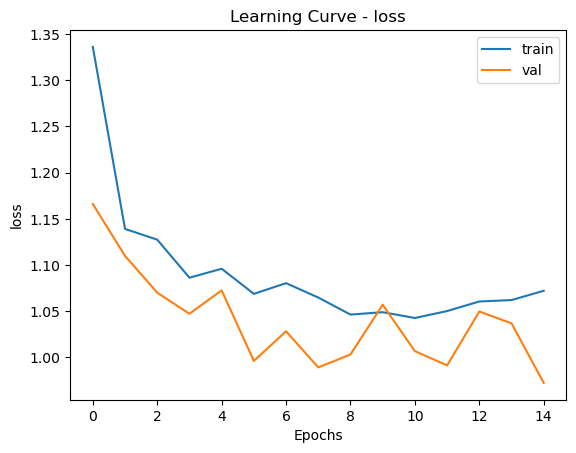

In [26]:
# MLP model for cell type
model_mlp_cell = Sequential([
    Input(shape=(27, 27, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_mlp_cell.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mlp_cell.summary()

history_mlp_cell = model_mlp_cell.fit(train_gen_cell, validation_data=val_gen_cell, epochs=15, verbose=2)
model_mlp_cell.save('mlp_celltype_classifier_model.keras')
plot_learning_curve(history_mlp_cell, 'accuracy')
plot_learning_curve(history_mlp_cell, 'loss')

### The MLP model for multi-class cell type classification shows moderate improvement during training. It starts with a low accuracy of ~41% and gradually reaches around 55% training accuracy and 59% validation accuracy by epoch 15. The loss steadily declines, indicating convergence, but both accuracy curves plateau early, suggesting underfitting.

### Compared to CNNs, this MLP model lacks spatial feature extraction, which is crucial for histopathological images. The relatively shallow architecture likely limits its ability to capture complex morphological differences between cell types. To improve performance, deeper CNNs or hybrid models with convolutional and dense layers are recommended.

## Step 10: Define a deepr CNN model for binary classification

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 27, 27, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,162 (1.10 MB)

 Trainable params: 287,714 (1.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
185/185 - 11s - 59ms/step - accuracy: 0.8348 - loss: 0.4273 - val_accuracy: 0.4103 - val_loss: 8.2524
Epoch 2/20
185/185 - 17s - 91ms/step - accuracy: 0.8816 - loss: 0.3124 - val_accuracy: 0.4457 - val_loss: 3.9302
Epoch 3/20
185/185 - 17s - 92ms/step - accuracy: 0.8811 - loss: 0.3032 - val_accuracy: 0.5666 - val_loss: 1.7296
Epoch 4/20
185/185 - 15s - 79ms/step - accuracy: 0.8927 - loss: 0.2743 - val_accuracy: 0.9062 - val_loss: 0.2904
Epoch 5/20
185/185 - 15s - 80ms/step - accuracy: 0.8985 - loss: 0.2680 - val_accuracy: 0.9016 - val_loss: 0.2889
Epoch 6/20
185/185 - 14s - 78ms/step - accuracy: 0.9047 - loss: 0.2553 - val_accuracy: 0.7833 - val_loss: 0.7521
Epoch 7/20
185/185 - 14s - 78ms/step - accuracy: 0.9079 - loss: 0.2413 - val_accuracy: 0.9093 - val_loss: 0.2244
Epoch 8/20
185/185 - 16s - 87ms/step - accuracy: 0.9108 - loss: 0.2354 - val_accuracy: 0.8719 - val_loss: 0.4398
Epoch 9/20
185/185 - 14s - 76ms/step - accuracy: 0.9130 - loss: 0.2296 - val_accuracy: 0.7823 - 

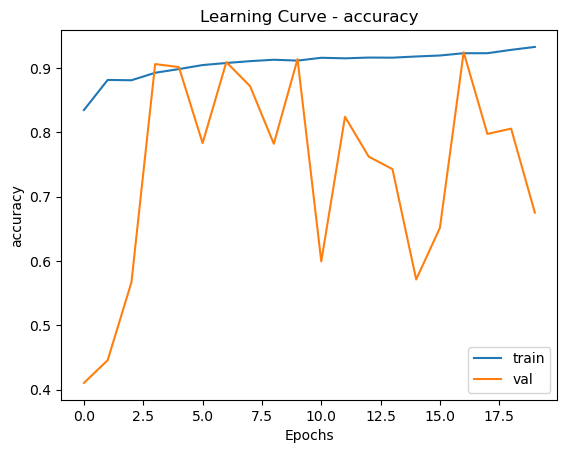

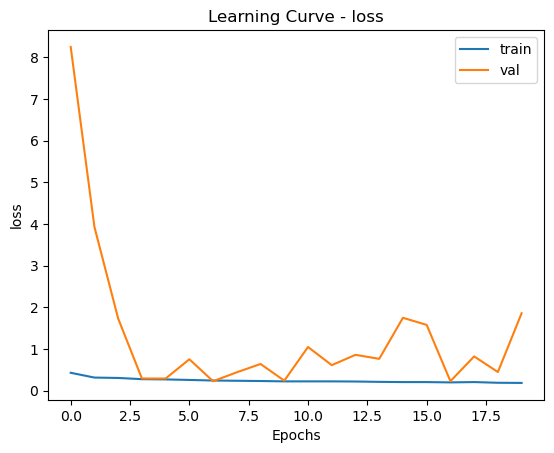

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

# Deeper cnn model
model_deep_cnn_cancer = Sequential([
    # Input layer specifying image shape
    Input(shape=(27, 27, 3)),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # learn 32 3x3 filters
    BatchNormalization(),  # Normalize activations to help speed up training
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # another 3x3 conv layer
    MaxPooling2D(pool_size=(2, 2)),  # Downsample spatial dimensions by 2
    Dropout(0.25),  # Dropout to reduce overfitting

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the 3D feature maps to 1D feature vector
    Flatten(),

    # Fully connected (dense) layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Stronger dropout to further prevent overfitting

    # Output layer with 2 nodes (binary classification: cancerous or not)
    Dense(2, activation='softmax')  # softmax for categorical output
])

# Compile the model with appropriate optimizer, loss and metric
model_deep_cnn_cancer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model_deep_cnn_cancer.summary()
history_deep_cnn_cancer = model_deep_cnn_cancer.fit(train_gen_cancer, validation_data=val_gen_cancer, epochs=20, verbose=2)

# Save the trained model in Keras format
model_deep_cnn_cancer.save("deep_cnn_cancer_classifier_model.keras")

# Plot the learning curves (accuracy and loss)
plot_learning_curve(history_deep_cnn_cancer, 'accuracy')  # training vs. validation accuracy
plot_learning_curve(history_deep_cnn_cancer, 'loss')       # training vs. validation loss


### The provided code implements a deeper Convolutional Neural Network (CNN) in Keras to classify histopathology images as cancerous or non-cancerous using RGB image patches (27×27 pixels). The model consists of three convolutional blocks, each including two convolutional layers with ReLU activations and padding='same', followed by Batch Normalization to stabilize training, MaxPooling to downsample feature maps, and Dropout to prevent overfitting. The features are then flattened and passed through a fully connected dense layer with 128 units and a final softmax layer with 2 units for binary classification.

### The model achieves high training accuracy (~93%) and initially strong validation accuracy (up to 91%) but eventually shows signs of overfitting. After epoch 10, the validation loss increases significantly, while accuracy declines. This indicates the model is learning training-specific patterns that don't generalize well. Potential improvements include using early stopping, learning rate scheduling, or data augmentation. Overall, the deeper CNN performs well but may need regularization or more diverse data to sustain high generalization performance

## Step 11: Deeper CNN for cell type classification

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 27, 27, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,508 (1.38 MB)

 Trainable params: 361,316 (1.38 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
185/185 - 13s - 71ms/step - accuracy: 0.6008 - loss: 1.0225 - val_accuracy: 0.4088 - val_loss: 2.7606
Epoch 2/20
185/185 - 12s - 66ms/step - accuracy: 0.6713 - loss: 0.8545 - val_accuracy: 0.4477 - val_loss: 1.9223
Epoch 3/20
185/185 - 14s - 77ms/step - accuracy: 0.6956 - loss: 0.8045 - val_accuracy: 0.7300 - val_loss: 0.7272
Epoch 4/20
185/185 - 12s - 65ms/step - accuracy: 0.7106 - loss: 0.7727 - val_accuracy: 0.6675 - val_loss: 0.8076
Epoch 5/20
185/185 - 14s - 76ms/step - accuracy: 0.7199 - loss: 0.7437 - val_accuracy: 0.7193 - val_loss: 0.7282
Epoch 6/20
185/185 - 13s - 71ms/step - accuracy: 0.7297 - loss: 0.7190 - val_accuracy: 0.6173 - val_loss: 0.9744
Epoch 7/20
185/185 - 15s - 80ms/step - accuracy: 0.7380 - loss: 0.6966 - val_accuracy: 0.5727 - val_loss: 1.3294
Epoch 8/20
185/185 - 17s - 90ms/step - accuracy: 0.7405 - loss: 0.6831 - val_accuracy: 0.7377 - val_loss: 0.6991
Epoch 9/20
185/185 - 21s - 115ms/step - accuracy: 0.7373 - loss: 0.6823 - val_accuracy: 0.4462 -

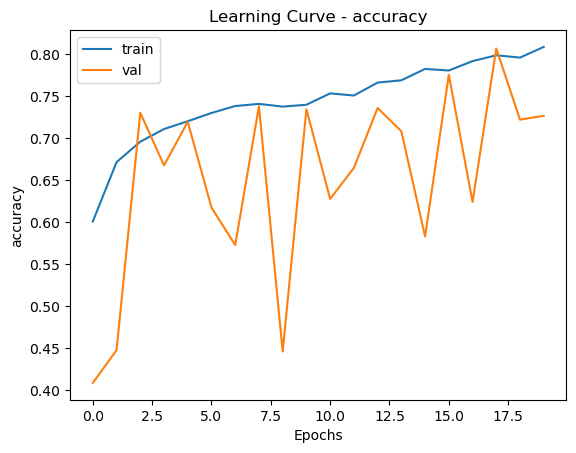

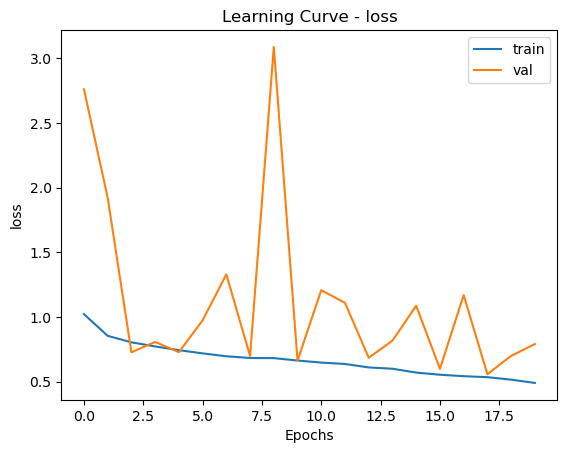

In [42]:
# Deeper CNN model
model_deep_cnn_cell = Sequential([
    Input(shape=(27, 27, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes for cell types
])

# Compile the model
model_deep_cnn_cell.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Summary
model_deep_cnn_cell.summary()

# Training
history_deep_cnn_cell = model_deep_cnn_cell.fit(train_gen_cell, validation_data=val_gen_cell, epochs=20, verbose=2)

# Save the model
model_deep_cnn_cancer.save("deep_cnn_cancer_cnn_model.keras")

# Plot training performance
plot_learning_curve(history_deep_cnn_cell, 'accuracy')
plot_learning_curve(history_deep_cnn_cell, 'loss')


### The deeper CNN model for cell-type classification demonstrates a significant increase in model complexity and learning capacity. It uses multiple convolutional blocks with Conv2D, BatchNormalization, and Dropout layers to extract high-level features and improve generalization. Initially, the model performs well, achieving up to 82% training accuracy by epoch 13. However, the validation accuracy peaks around epoch  17-18 at approximately 75% before gradually declining, while the validation loss continuously increases after this point.

### This is a clear sign of overfitting—the model has started memorizing training data and is no longer improving generalization to unseen validation data. Despite added dropout layers to prevent overfitting, the model's high capacity and small input size (27×27×3) limit the generalizability without further regularization or data augmentation.

### In conclusion, while the deeper model learns complex representations effectively, its validation performance suffers due to overfitting. Future work should include implementing early stopping, learning rate reduction, and strong data augmentation (rotation, zoom, flips) to enhance robustness and reduce validation loss. A more balanced architecture with slightly fewer filters or training with more data could also yield better real-world performance.